['year', 'pH', 'EC', 'Phosphorus', 'Potassium', 'OM', 'Urea1', 'Urea2', 'Urea3', 'Urea4', 'TSP0', 'MOP1', 'MOP2', 'MOP3', 'temperature_2m_max', 'temperature_2m_min', 'sunshine_duration', 'rain_sum', 'wind_speed_10m_max', 'et0_fao_evapotranspiration_sum', 'Season', 'Condition_Rain', 'Condition_Tank']
Epoch 1/100


d:\Projects\CDP\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1511 - mean_absolute_error: 0.7871 - val_loss: 0.3603 - val_mean_absolute_error: 0.4552 - learning_rate: 0.0078
Epoch 2/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4129 - mean_absolute_error: 0.4907 - val_loss: 0.3009 - val_mean_absolute_error: 0.4192 - learning_rate: 0.0078
Epoch 3/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3747 - mean_absolute_error: 0.4666 - val_loss: 0.2792 - val_mean_absolute_error: 0.4012 - learning_rate: 0.0078
Epoch 4/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3476 - mean_absolute_error: 0.4504 - val_loss: 0.2588 - val_mean_absolute_error: 0.3938 - learning_rate: 0.0078
Epoch 5/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3285 - mean_absolute_error: 0.4388 - val_loss: 0.2344 - val_mean_absolute_error: 0.3675 - learning_rate: 0.0078
Epoch 6/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3088 - mean_absolute_error: 0.4256 - val_loss: 0.2270 - val_mean_absolute_

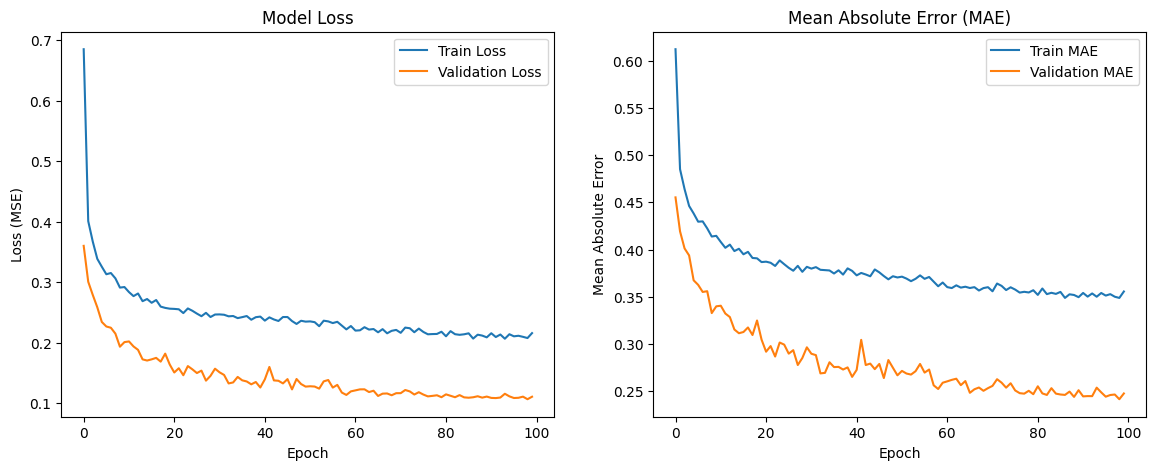

['scaler_y.pkl']

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD

final_combined_data_cleaned = pd.read_excel('6. final_dataset.xlsx')
final_combined_data_cleaned['Phosphorus'] = np.log1p(final_combined_data_cleaned['Phosphorus'])
final_combined_data_cleaned['Potassium'] = np.log1p(final_combined_data_cleaned['Potassium'])
final_combined_data_cleaned['OM'] = np.log1p(final_combined_data_cleaned['OM'])
final_combined_data_cleaned['EC'] = np.log1p(final_combined_data_cleaned['EC'])
final_combined_data_cleaned['temperature_2m_max'] = np.cbrt(final_combined_data_cleaned['temperature_2m_max'])
final_combined_data_cleaned['temperature_2m_min'] = np.cbrt(final_combined_data_cleaned['temperature_2m_min'])
final_combined_data_cleaned['rain_sum'] = np.cbrt(final_combined_data_cleaned['rain_sum'])
final_combined_data_cleaned['sunshine_duration'] = np.cbrt(final_combined_data_cleaned['sunshine_duration'])
final_combined_data_cleaned['wind_speed_10m_max'] = np.cbrt(final_combined_data_cleaned['wind_speed_10m_max'])
final_combined_data_cleaned['et0_fao_evapotranspiration_sum'] = np.cbrt(final_combined_data_cleaned['et0_fao_evapotranspiration_sum'])

label_encoder = LabelEncoder()
final_combined_data_cleaned['Season'] = label_encoder.fit_transform(final_combined_data_cleaned['season'])

final_combined_data_encoded = pd.get_dummies(final_combined_data_cleaned, columns=['Condition'])

features = ['year', 'pH', 'EC', 'Phosphorus', 'Potassium', 'OM', 
            'Urea1', 'Urea2', 'Urea3', 'Urea4', 
            'TSP0', 'MOP1', 'MOP2', 'MOP3', 
            'temperature_2m_max', 'temperature_2m_min', 
            'sunshine_duration', 'rain_sum', 
            'wind_speed_10m_max', 
            'et0_fao_evapotranspiration_sum', 
            'Season']

features.extend([col for col in final_combined_data_encoded.columns if col.startswith('Condition_')]) 


print(features)

X = final_combined_data_encoded[features]
y = final_combined_data_encoded['Yield']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Convert data to float32 for Keras
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Build the MLP model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(32, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(1))

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.007775645935042448), loss='mean_squared_error', metrics=['mean_absolute_error'])

# Add Early Stopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1,
                    callbacks=[early_stopping, reduce_lr])

# Plotting the loss and MAE (mean absolute error)
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend(loc='upper right')

# Plot MAE (as a measure of error)
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')

plt.show()

import joblib

model.save('trained_model.h5')
joblib.dump(scaler, 'scaler_X.pkl')
joblib.dump(y_scaler, 'scaler_y.pkl')


In [4]:
from tensorflow.keras.models import load_model

scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

# Load the trained model
model = load_model('trained_model.h5')

In [5]:
print(features)

['year', 'pH', 'EC', 'Phosphorus', 'Potassium', 'OM', 'Urea1', 'Urea2', 'Urea3', 'Urea4', 'TSP0', 'MOP1', 'MOP2', 'MOP3', 'temperature_2m_max', 'temperature_2m_min', 'sunshine_duration', 'rain_sum', 'wind_speed_10m_max', 'et0_fao_evapotranspiration_sum', 'Season', 'Condition_Rain', 'Condition_Tank']


In [6]:
import numpy as np
import pandas as pd

# Example test data (replace with your own input values)
test_data = {
    'year': [2024],
    'pH': [6.0],
    'EC': [1.5],
    'Phosphorus': [34.5],
    'Potassium': [217.8],
    'OM': [3.5],
    'Urea1': [40],
    'Urea2': [26],
    'Urea3': [20],
    'Urea4': [12],
    'TSP0': [0],
    'MOP1': [0],
    'MOP2': [10],
    'MOP3': [10],
    'temperature_2m_max': [35],
    'temperature_2m_min': [25],
    'sunshine_duration': [8],
    'rain_sum': [50],
    'wind_speed_10m_max': [15],
    'et0_fao_evapotranspiration_sum': [120],
    'Season': [1],  # Example encoded value for the season
    'Condition_Rain': [1],  # Example condition (Rain)
    'Condition_Tank': [0]  # Example condition (Tank)
}

# Convert to DataFrame
test_df = pd.DataFrame(test_data)

# Apply the same transformations as the training data
# Log and cubic transformations (if needed)
test_df['Phosphorus'] = np.log1p(test_df['Phosphorus'])
test_df['Potassium'] = np.log1p(test_df['Potassium'])
test_df['OM'] = np.log1p(test_df['OM'])
test_df['EC'] = np.log1p(test_df['EC'])
test_df['temperature_2m_max'] = np.cbrt(test_df['temperature_2m_max'])
test_df['temperature_2m_min'] = np.cbrt(test_df['temperature_2m_min'])
test_df['rain_sum'] = np.cbrt(test_df['rain_sum'])
test_df['sunshine_duration'] = np.cbrt(test_df['sunshine_duration'])
test_df['wind_speed_10m_max'] = np.cbrt(test_df['wind_speed_10m_max'])
test_df['et0_fao_evapotranspiration_sum'] = np.cbrt(test_df['et0_fao_evapotranspiration_sum'])

# Scale the features
X_test_scaled = scaler_X.transform(test_df)

# Make predictions
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform to get the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Show the prediction result
print("Predicted Yield:", y_pred[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Predicted Yield: 4530.3584


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

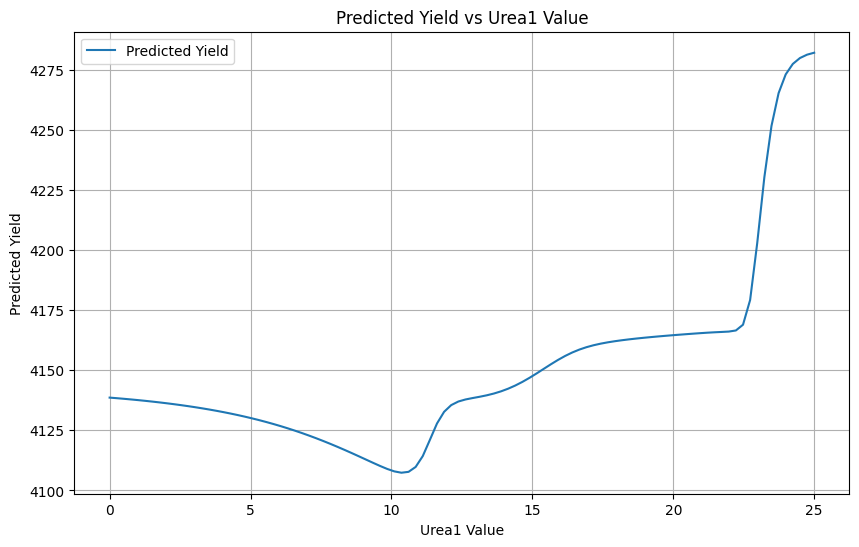

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the range of Urea1 values
urea1_values = np.linspace(0, 25, 100)  # 100 values from 0 to 25

# Initialize the plot for the yield vs Urea1
yields = []

# Loop through Urea1 values and make predictions
for urea1 in urea1_values:
    # Create the test data dictionary with the current Urea1 value
    test_data = {
        'year': [2024],
        'pH': [6.0],
        'EC': [1.5],
        'Phosphorus': [34.5],
        'Potassium': [217.8],
        'OM': [3.5],
        'Urea1': [urea1],  # Update Urea1 value in the loop
        'Urea2': [26],
        'Urea3': [20],
        'Urea4': [12],
        'TSP0': [0],
        'MOP1': [0],
        'MOP2': [10],
        'MOP3': [10],
        'temperature_2m_max': [35],
        'temperature_2m_min': [25],
        'sunshine_duration': [8],
        'rain_sum': [50],
        'wind_speed_10m_max': [15],
        'et0_fao_evapotranspiration_sum': [120],
        'Season': [1],  # Example encoded value for the season
        'Condition_Rain': [1],  # Example condition (Rain)
        'Condition_Tank': [0]  # Example condition (Tank)
    }

    # Convert to DataFrame
    test_df = pd.DataFrame(test_data)

    # Apply the same transformations as the training data
    # Log and cubic transformations (if needed)
    test_df['Phosphorus'] = np.log1p(test_df['Phosphorus'])
    test_df['Potassium'] = np.log1p(test_df['Potassium'])
    test_df['OM'] = np.log1p(test_df['OM'])
    test_df['EC'] = np.log1p(test_df['EC'])
    test_df['temperature_2m_max'] = np.cbrt(test_df['temperature_2m_max'])
    test_df['temperature_2m_min'] = np.cbrt(test_df['temperature_2m_min'])
    test_df['rain_sum'] = np.cbrt(test_df['rain_sum'])
    test_df['sunshine_duration'] = np.cbrt(test_df['sunshine_duration'])
    test_df['wind_speed_10m_max'] = np.cbrt(test_df['wind_speed_10m_max'])
    test_df['et0_fao_evapotranspiration_sum'] = np.cbrt(test_df['et0_fao_evapotranspiration_sum'])

    # Scale the features
    X_test_scaled = scaler_X.transform(test_df)

    # Make predictions
    y_pred_scaled = model.predict(X_test_scaled)

    # Inverse transform to get the original scale
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Append the predicted yield to the list
    yields.append(y_pred[0][0])

# Plot the predicted yields against Urea1 values
plt.figure(figsize=(10, 6))
plt.plot(urea1_values, yields, label='Predicted Yield')
plt.title('Predicted Yield vs Urea1 Value')
plt.xlabel('Urea1 Value')
plt.ylabel('Predicted Yield')
plt.grid(True)
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

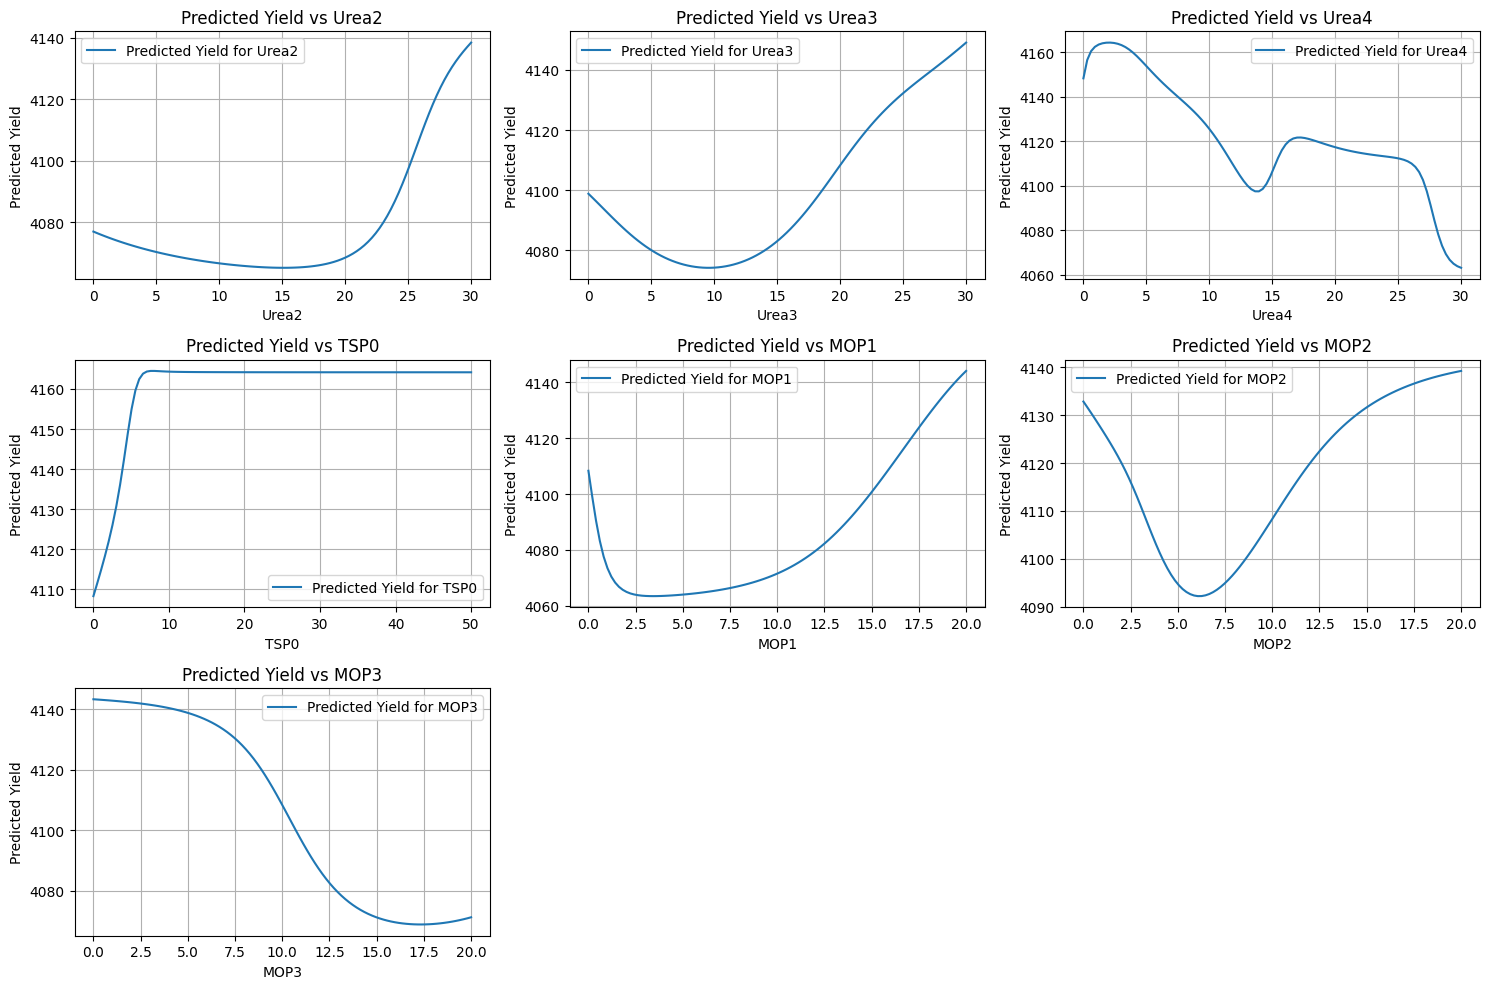

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# List of features you want to plot
urea_values = {
    'Urea2': np.linspace(0, 30, 100),  # Range for Urea2
    'Urea3': np.linspace(0, 30, 100),  # Range for Urea3
    'Urea4': np.linspace(0, 30, 100),  # Range for Urea4
    'TSP0': np.linspace(0, 50, 100),   # Range for TSP0
    'MOP1': np.linspace(0, 20, 100),   # Range for MOP1
    'MOP2': np.linspace(0, 20, 100),   # Range for MOP2
    'MOP3': np.linspace(0, 20, 100)    # Range for MOP3
}

# Initialize figure for the plots
plt.figure(figsize=(15, 10))

# Loop through each feature to plot
for idx, (feature, values) in enumerate(urea_values.items()):
    yields = []
    
    # Loop through values of the current feature
    for value in values:
        # Create the test data dictionary with the current feature value
        test_data = {
            'year': [2024],
            'pH': [6.0],
            'EC': [1.5],
            'Phosphorus': [34.5],
            'Potassium': [217.8],
            'OM': [3.5],
            'Urea1': [10],  # Fixed value for Urea1
            'Urea2': [value] if feature == 'Urea2' else [26],  # Update only the current feature
            'Urea3': [value] if feature == 'Urea3' else [20],  # Update only the current feature
            'Urea4': [value] if feature == 'Urea4' else [12],  # Update only the current feature
            'TSP0': [value] if feature == 'TSP0' else [0],     # Update only the current feature
            'MOP1': [value] if feature == 'MOP1' else [0],     # Update only the current feature
            'MOP2': [value] if feature == 'MOP2' else [10],    # Update only the current feature
            'MOP3': [value] if feature == 'MOP3' else [10],    # Update only the current feature
            'temperature_2m_max': [35],
            'temperature_2m_min': [25],
            'sunshine_duration': [8],
            'rain_sum': [50],
            'wind_speed_10m_max': [15],
            'et0_fao_evapotranspiration_sum': [120],
            'Season': [1],  
            'Condition_Rain': [1],  
            'Condition_Tank': [0] 
        }

        # Convert to DataFrame
        test_df = pd.DataFrame(test_data)

        # Apply the same transformations as the training data
        test_df['Phosphorus'] = np.log1p(test_df['Phosphorus'])
        test_df['Potassium'] = np.log1p(test_df['Potassium'])
        test_df['OM'] = np.log1p(test_df['OM'])
        test_df['EC'] = np.log1p(test_df['EC'])
        test_df['temperature_2m_max'] = np.cbrt(test_df['temperature_2m_max'])
        test_df['temperature_2m_min'] = np.cbrt(test_df['temperature_2m_min'])
        test_df['rain_sum'] = np.cbrt(test_df['rain_sum'])
        test_df['sunshine_duration'] = np.cbrt(test_df['sunshine_duration'])
        test_df['wind_speed_10m_max'] = np.cbrt(test_df['wind_speed_10m_max'])
        test_df['et0_fao_evapotranspiration_sum'] = np.cbrt(test_df['et0_fao_evapotranspiration_sum'])

        # Scale the features
        X_test_scaled = scaler_X.transform(test_df)

        # Make predictions
        y_pred_scaled = model.predict(X_test_scaled)

        # Inverse transform to get the original scale
        y_pred = scaler_y.inverse_transform(y_pred_scaled)

        # Append the predicted yield to the list
        yields.append(y_pred[0][0])

    # Plot for the current feature
    plt.subplot(3, 3, idx+1)  # Arrange the plots in a 3x3 grid
    plt.plot(values, yields, label=f'Predicted Yield for {feature}')
    plt.title(f'Predicted Yield vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Predicted Yield')
    plt.grid(True)
    plt.legend()

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

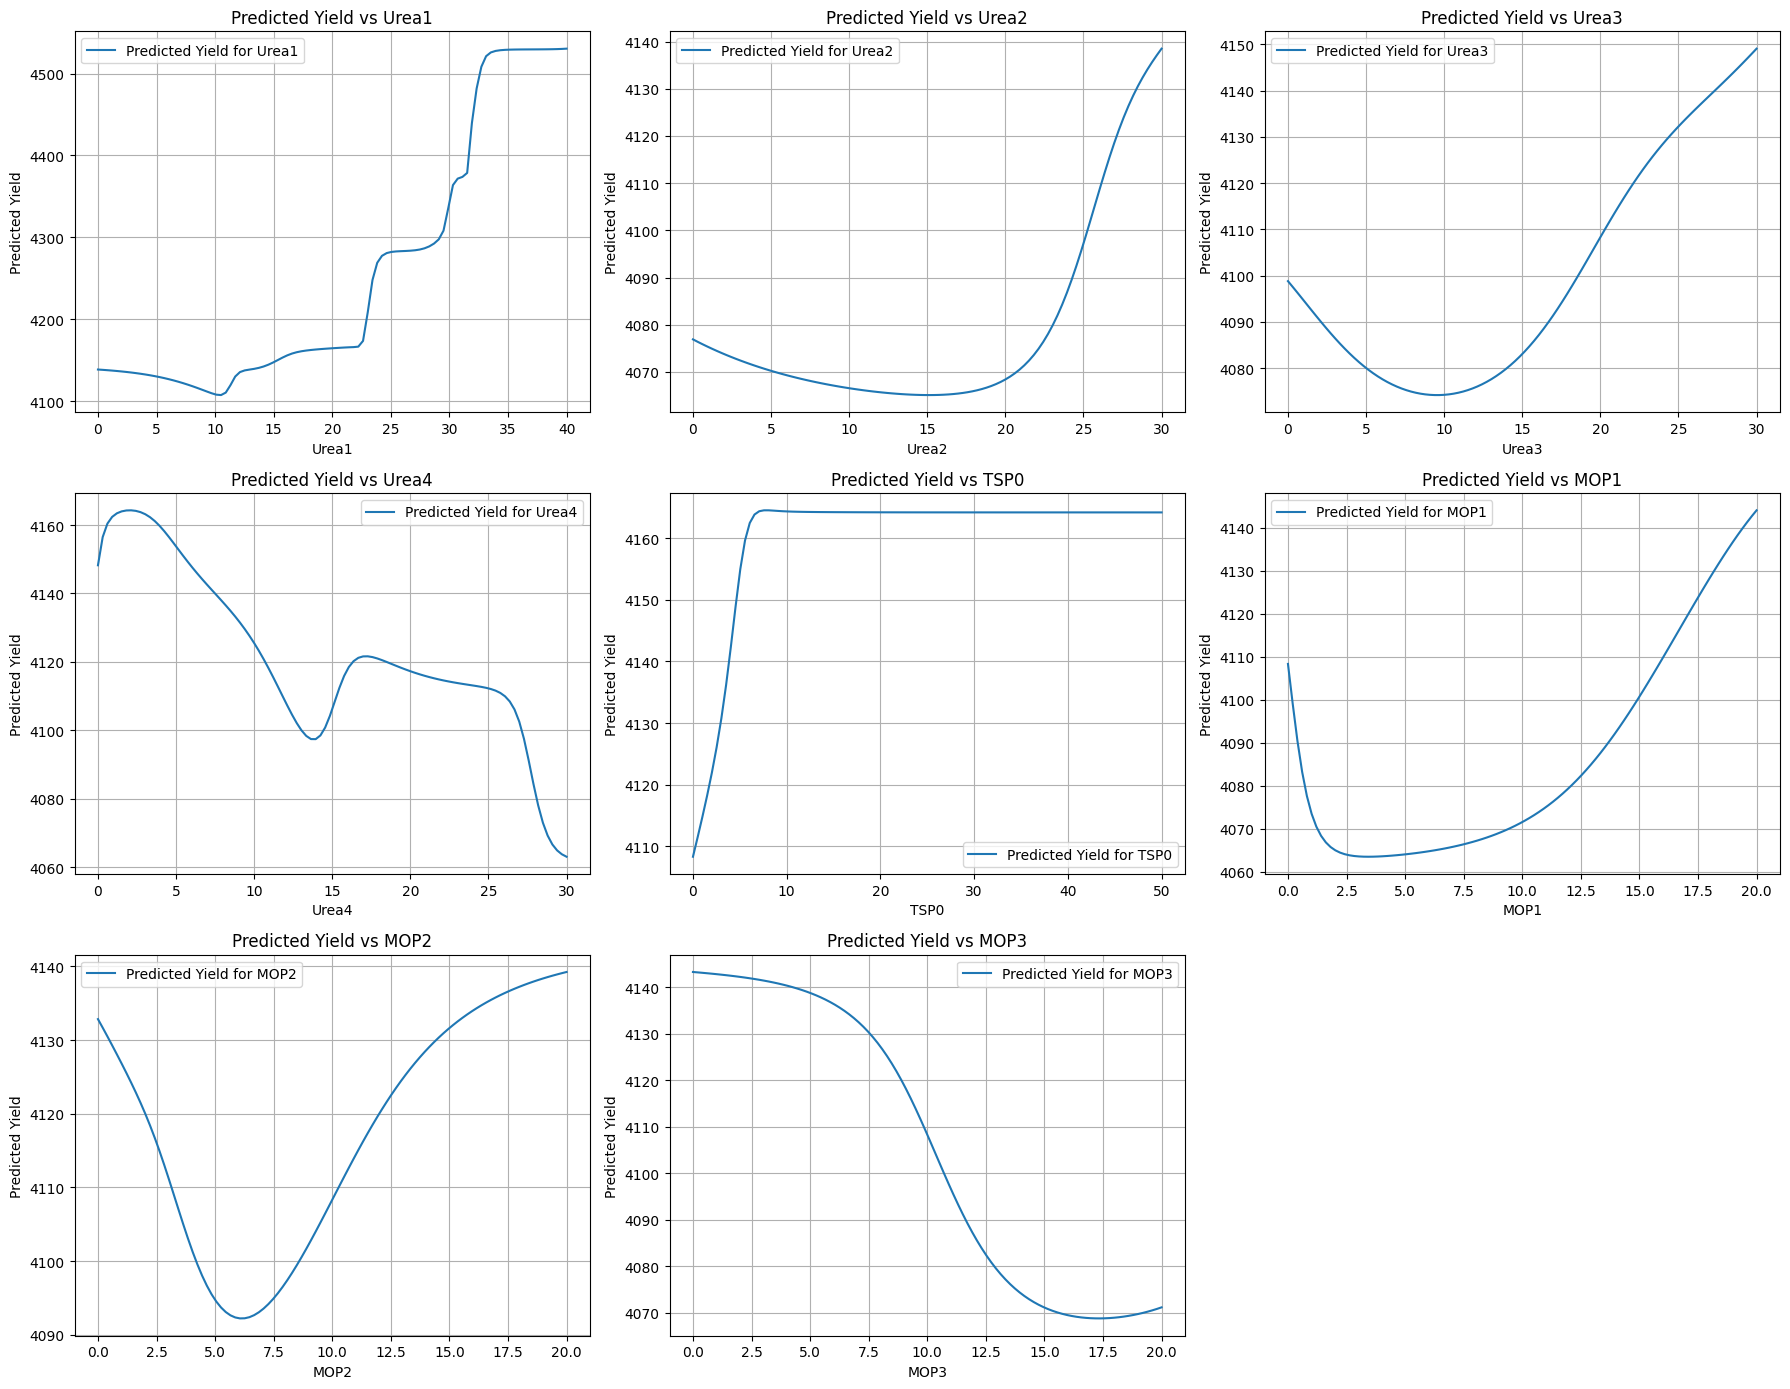

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# List of features you want to plot
parameters = {
    'Urea1': np.linspace(0, 40, 100),  # Range for Urea1
    'Urea2': np.linspace(0, 30, 100),  # Range for Urea2
    'Urea3': np.linspace(0, 30, 100),  # Range for Urea3
    'Urea4': np.linspace(0, 30, 100),  # Range for Urea4
    'TSP0': np.linspace(0, 50, 100),   # Range for TSP0
    'MOP1': np.linspace(0, 20, 100),   # Range for MOP1
    'MOP2': np.linspace(0, 20, 100),   # Range for MOP2
    'MOP3': np.linspace(0, 20, 100)    # Range for MOP3
}

# Initialize figure for the plots
plt.figure(figsize=(18, 14))

# Loop through each feature to plot
for idx, (feature, values) in enumerate(parameters.items()):
    yields = []
    
    # Loop through values of the current feature
    for value in values:
        # Create the test data dictionary with the current feature value
        test_data = {
            'year': [2024],
            'pH': [6.0],
            'EC': [1.5],
            'Phosphorus': [34.5],
            'Potassium': [217.8],
            'OM': [3.5],
            'Urea1': [value] if feature == 'Urea1' else [10],  # Update only the current feature
            'Urea2': [value] if feature == 'Urea2' else [26],  # Update only the current feature
            'Urea3': [value] if feature == 'Urea3' else [20],  # Update only the current feature
            'Urea4': [value] if feature == 'Urea4' else [12],  # Update only the current feature
            'TSP0': [value] if feature == 'TSP0' else [0],     # Update only the current feature
            'MOP1': [value] if feature == 'MOP1' else [0],     # Update only the current feature
            'MOP2': [value] if feature == 'MOP2' else [10],    # Update only the current feature
            'MOP3': [value] if feature == 'MOP3' else [10],    # Update only the current feature
            'temperature_2m_max': [35],
            'temperature_2m_min': [25],
            'sunshine_duration': [8],
            'rain_sum': [50],
            'wind_speed_10m_max': [15],
            'et0_fao_evapotranspiration_sum': [120],
            'Season': [1],  # Example encoded value for the season
            'Condition_Rain': [1],  # Example condition (Rain)
            'Condition_Tank': [0]  # Example condition (Tank)
        }

        # Convert to DataFrame
        test_df = pd.DataFrame(test_data)

        # Apply the same transformations as the training data
        test_df['Phosphorus'] = np.log1p(test_df['Phosphorus'])
        test_df['Potassium'] = np.log1p(test_df['Potassium'])
        test_df['OM'] = np.log1p(test_df['OM'])
        test_df['EC'] = np.log1p(test_df['EC'])
        test_df['temperature_2m_max'] = np.cbrt(test_df['temperature_2m_max'])
        test_df['temperature_2m_min'] = np.cbrt(test_df['temperature_2m_min'])
        test_df['rain_sum'] = np.cbrt(test_df['rain_sum'])
        test_df['sunshine_duration'] = np.cbrt(test_df['sunshine_duration'])
        test_df['wind_speed_10m_max'] = np.cbrt(test_df['wind_speed_10m_max'])
        test_df['et0_fao_evapotranspiration_sum'] = np.cbrt(test_df['et0_fao_evapotranspiration_sum'])

        # Scale the features
        X_test_scaled = scaler_X.transform(test_df)

        # Make predictions
        y_pred_scaled = model.predict(X_test_scaled)

        # Inverse transform to get the original scale
        y_pred = scaler_y.inverse_transform(y_pred_scaled)

        # Append the predicted yield to the list
        yields.append(y_pred[0][0])

    # Plot for the current feature
    plt.subplot(3, 3, idx+1)  # Arrange the plots in a 3x3 grid
    plt.plot(values, yields, label=f'Predicted Yield for {feature}')
    plt.title(f'Predicted Yield vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Predicted Yield')
    plt.grid(True)
    plt.legend()

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


### 3

### optimize CSOA

Total hyperparameter combinations: 8
Starting grid search...

--- Hyperparameter Combination 1/8 ---
Running CSO with hyperparameters: {'population_size': 10, 'max_iterations': 25, 'pa': 0.25}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Iteration 0, Best Yield: 4529.3384
1/1 ━━━━━━━

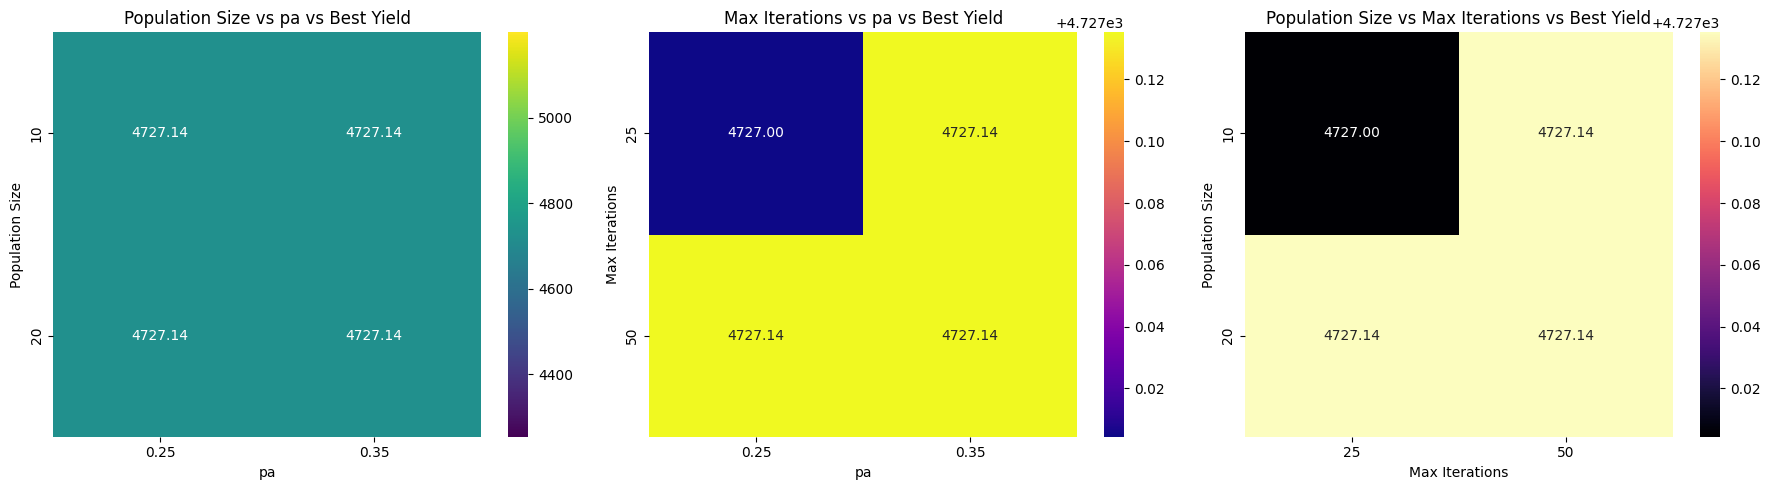

In [ ]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
import math
import matplotlib.pyplot as plt
from random import randint
from itertools import product
import seaborn as sns

scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

model = load_model('trained_model.h5')

def objective_function(params):

    test_data = {
        'year': [2024],
        'pH': [6.0],
        'EC': [1.5],
        'Phosphorus': [34.5],
        'Potassium': [217.8],
        'OM': [3.5],
        'Urea1': [params[0]],
        'Urea2': [params[1]],
        'Urea3': [params[2]],
        'Urea4': [params[3]],
        'TSP0': [params[4]],
        'MOP1': [params[5]],
        'MOP2': [params[6]],
        'MOP3': [params[7]],
        'temperature_2m_max': [35],
        'temperature_2m_min': [25],
        'sunshine_duration': [8],
        'rain_sum': [50],
        'wind_speed_10m_max': [15],
        'et0_fao_evapotranspiration_sum': [120],
        'Season': [1],
        'Condition_Rain': [1],
        'Condition_Tank': [0]
    }

    test_df = pd.DataFrame(test_data)

    test_df['Phosphorus'] = np.log1p(test_df['Phosphorus'])
    test_df['Potassium'] = np.log1p(test_df['Potassium'])
    test_df['OM'] = np.log1p(test_df['OM'])
    test_df['EC'] = np.log1p(test_df['EC'])
    test_df['temperature_2m_max'] = np.cbrt(test_df['temperature_2m_max'])
    test_df['temperature_2m_min'] = np.cbrt(test_df['temperature_2m_min'])
    test_df['rain_sum'] = np.cbrt(test_df['rain_sum'])
    test_df['sunshine_duration'] = np.cbrt(test_df['sunshine_duration'])
    test_df['wind_speed_10m_max'] = np.cbrt(test_df['wind_speed_10m_max'])
    test_df['et0_fao_evapotranspiration_sum'] = np.cbrt(test_df['et0_fao_evapotranspiration_sum'])

    # Handle one-hot encoded 'Condition_' columns
    condition_cols = [col for col in scaler_X.feature_names_in_ if col.startswith('Condition_')]
    for col in condition_cols:
        if col not in test_df.columns:
            test_df[col] = 0 

    test_df = test_df[scaler_X.feature_names_in_]
    X_test_scaled = scaler_X.transform(test_df)
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    return -y_pred[0][0]

class CuckooSearch:
    def __init__(self, objective_function, bounds, population_size=10, max_iterations=100, pa=0.25):
        self.objective_function = objective_function  
        self.bounds = bounds  
        self.population_size = population_size  
        self.max_iterations = max_iterations  
        self.pa = pa  

        # Initialize population and scores
        self.population = np.random.uniform(bounds[:, 0], bounds[:, 1], (population_size, len(bounds)))
        self.scores = np.array([self.objective_function(ind) for ind in self.population])

        self.best_solution = self.population[np.argmin(self.scores)]
        self.best_score = np.min(self.scores)
        self.history = [self.best_score]  

    def levy_flight(self, x):
        beta = 1.5
        sigma = (math.gamma(1 + beta) * math.sin(math.pi * beta / 2) / math.gamma((1 + beta) / 2))
        s = np.random.normal(0, sigma, size=x.shape)
        return x + s

    def update_population(self):
        for i in range(self.population_size):
            j = randint(0, self.population_size - 1)
            if i != j:
                step = self.population[i] + np.random.normal(0, 1, size=self.population[i].shape) * (self.population[i] - self.population[j])
                new_solution = np.clip(step, self.bounds[:, 0], self.bounds[:, 1])
                new_score = self.objective_function(new_solution)

                if new_score < self.scores[i]:
                    self.population[i] = new_solution
                    self.scores[i] = new_score

            if np.random.rand() < self.pa:
                new_solution = self.levy_flight(self.population[i])
                new_solution = np.clip(new_solution, self.bounds[:, 0], self.bounds[:, 1])

                new_score = self.objective_function(new_solution)

                if new_score < self.scores[i]:
                    self.population[i] = new_solution
                    self.scores[i] = new_score

        # Update the best solution found
        best_index = np.argmin(self.scores)
        if self.scores[best_index] < self.best_score:
            self.best_solution = self.population[best_index]
            self.best_score = self.scores[best_index]

        # Record the best score for convergence tracking
        self.history.append(self.best_score)

    def optimize(self):
        for iteration in range(self.max_iterations):
            self.update_population()
            if iteration % 10 == 0:
                print(f"Iteration {iteration}, Best Yield: {-self.best_score:.4f}")  # Negate to show positive yield
        return self.best_solution, -self.best_score  # Return positive yield


hyperparameter_grid = {
    'population_size': [10, 20],  # Example values
    'max_iterations': [25, 50],
    'pa': [0.25, 0.35],
}

# Generate all combinations of hyperparameters
keys, values = zip(*hyperparameter_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in product(*values)]

print(f"Total hyperparameter combinations: {len(hyperparameter_combinations)}")


param_bounds = np.array([
    [0, 40],  # Urea1
    [0, 30],  # Urea2
    [0, 30],  # Urea3
    [0, 30],  # Urea4
    [0, 50],  # TSP0
    [0, 20],  # MOP1
    [0, 20],  # MOP2
    [0, 20],  # MOP3
])


def run_cso_hyperparameter_combination(hyperparams):
    print(f"Running CSO with hyperparameters: {hyperparams}")
    cs = CuckooSearch(
        objective_function=objective_function,
        bounds=param_bounds,
        population_size=hyperparams['population_size'],
        max_iterations=hyperparams['max_iterations'],
        pa=hyperparams['pa']
    )
    best_solution, best_score = cs.optimize()
    return {
        'population_size': hyperparams['population_size'],
        'max_iterations': hyperparams['max_iterations'],
        'pa': hyperparams['pa'],
        'best_yield': best_score,
        'best_solution': best_solution
    }


print("Starting grid search...")

grid_search_results = []
for idx, hyperparams in enumerate(hyperparameter_combinations, 1):
    print(f"\n--- Hyperparameter Combination {idx}/{len(hyperparameter_combinations)} ---")
    result = run_cso_hyperparameter_combination(hyperparams)
    grid_search_results.append(result)


results_df = pd.DataFrame(grid_search_results)

if not results_df.empty:
    best_result = results_df.loc[results_df['best_yield'].idxmax()]
    
    print("\nBest Hyperparameters Found:")
    print(f"Population Size: {best_result['population_size']}")
    print(f"Max Iterations: {best_result['max_iterations']}")
    print(f"pa: {best_result['pa']}")
    print(f"Best Yield: {best_result['best_yield']}")
    print(f"Best Solution: {best_result['best_solution']}")
else:
    print("No results to analyze.")

results_df.to_csv('cso_grid_search_results.csv', index=False)

if not results_df.empty and 'best_yield' in results_df.columns:
    plt.figure(figsize=(18, 5))
    
    
    pivot_pop = results_df.pivot_table(index='population_size', columns='pa', values='best_yield', aggfunc='max')
    plt.subplot(1, 3, 1)
    sns.heatmap(pivot_pop, annot=True, fmt=".2f", cmap='viridis')
    plt.title('Population Size vs pa vs Best Yield')
    plt.xlabel('pa')
    plt.ylabel('Population Size')
    
    
    pivot_iter = results_df.pivot_table(index='max_iterations', columns='pa', values='best_yield', aggfunc='max')
    plt.subplot(1, 3, 2)
    sns.heatmap(pivot_iter, annot=True, fmt=".2f", cmap='plasma')
    plt.title('Max Iterations vs pa vs Best Yield')
    plt.xlabel('pa')
    plt.ylabel('Max Iterations')
    
    
    pivot_pa = results_df.pivot_table(index='population_size', columns='max_iterations', values='best_yield', aggfunc='max')
    plt.subplot(1, 3, 3)
    sns.heatmap(pivot_pa, annot=True, fmt=".2f", cmap='magma')
    plt.title('Population Size vs Max Iterations vs Best Yield')
    plt.xlabel('Max Iterations')
    plt.ylabel('Population Size')
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for visualization.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

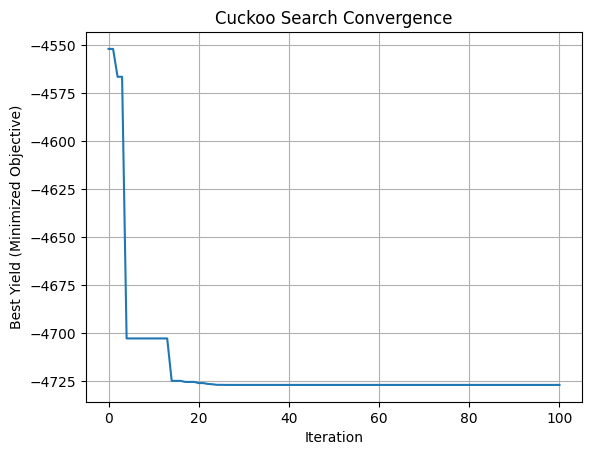

In [ ]:
import numpy as np
import pandas as pd
import joblib  # For loading scalers
from tensorflow.keras.models import load_model  # For loading the trained model
import math
import matplotlib.pyplot as plt
from random import randint

# Load the saved scalers
scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

# Load the trained model
model = load_model('trained_model.h5')

# Objective function to minimize (negative yield prediction)
def objective_function(params):
    """
    This function evaluates the 'fitness' of the solution (param values).
    It returns the predicted yield using the given values for Urea1, Urea2, etc.
    """
    # Convert params into dictionary for test data
    test_data = {
        'year': [2024],
        'pH': [6.0],
        'EC': [1.5],
        'Phosphorus': [34.5],
        'Potassium': [217.8],
        'OM': [3.5],
        'Urea1': [params[0]],  # Urea1
        'Urea2': [params[1]],  # Urea2
        'Urea3': [params[2]],  # Urea3
        'Urea4': [params[3]],  # Urea4
        'TSP0': [params[4]],   # TSP0
        'MOP1': [params[5]],   # MOP1
        'MOP2': [params[6]],   # MOP2
        'MOP3': [params[7]],   # MOP3
        'temperature_2m_max': [35],
        'temperature_2m_min': [25],
        'sunshine_duration': [8],
        'rain_sum': [50],
        'wind_speed_10m_max': [15],
        'et0_fao_evapotranspiration_sum': [120],
        'Season': [1],  # Example encoded value for the season
        'Condition_Rain': [1],  # Example condition (Rain)
        'Condition_Tank': [0]  # Example condition (Tank)
    }

    # Convert to DataFrame
    test_df = pd.DataFrame(test_data)

    # Apply the same transformations as the training data
    test_df['Phosphorus'] = np.log1p(test_df['Phosphorus'])
    test_df['Potassium'] = np.log1p(test_df['Potassium'])
    test_df['OM'] = np.log1p(test_df['OM'])
    test_df['EC'] = np.log1p(test_df['EC'])
    test_df['temperature_2m_max'] = np.cbrt(test_df['temperature_2m_max'])
    test_df['temperature_2m_min'] = np.cbrt(test_df['temperature_2m_min'])
    test_df['rain_sum'] = np.cbrt(test_df['rain_sum'])
    test_df['sunshine_duration'] = np.cbrt(test_df['sunshine_duration'])
    test_df['wind_speed_10m_max'] = np.cbrt(test_df['wind_speed_10m_max'])
    test_df['et0_fao_evapotranspiration_sum'] = np.cbrt(test_df['et0_fao_evapotranspiration_sum'])


    condition_cols = [col for col in scaler_X.feature_names_in_ if col.startswith('Condition_')]
    for col in condition_cols:
        if col not in test_df.columns:
            test_df[col] = 0  

    # Reorder columns to match the training data
    test_df = test_df[scaler_X.feature_names_in_]

    # Scale the features using the loaded scaler
    X_test_scaled = scaler_X.transform(test_df)

    # Predict using the loaded model
    y_pred_scaled = model.predict(X_test_scaled)

    # Inverse transform the prediction to get the actual yield
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Since the optimization minimizes the objective function, return negative yield
    return -y_pred[0][0]  # Assuming y_pred is a 2D array

# Define the CuckooSearch class (as previously defined)
class CuckooSearch:
    def __init__(self, objective_function, bounds, population_size=20, max_iterations=25, pa=0.25):
        self.objective_function = objective_function  
        self.bounds = bounds  
        self.population_size = population_size  
        self.max_iterations = max_iterations  
        self.pa = pa  

        # Initialize population and scores
        self.population = np.random.uniform(bounds[:, 0], bounds[:, 1], (population_size, len(bounds)))
        self.scores = np.array([self.objective_function(ind) for ind in self.population])

        self.best_solution = self.population[np.argmin(self.scores)]
        self.best_score = np.min(self.scores)
        self.history = [self.best_score]  

    def levy_flight(self, x):
        # Generate a Levy flight step (exploration strategy)
        beta = 1.5
        sigma = (math.gamma(1 + beta) * math.sin(math.pi * beta / 2) / math.gamma((1 + beta) / 2))
        s = np.random.normal(0, sigma, size=x.shape)
        return x + s

    def update_population(self):
        for i in range(self.population_size):
            j = randint(0, self.population_size - 1)
            if i != j:
                step = self.population[i] + np.random.normal(0, 1, size=self.population[i].shape) * (self.population[i] - self.population[j])
                new_solution = np.clip(step, self.bounds[:, 0], self.bounds[:, 1])
                new_score = self.objective_function(new_solution)

                if new_score < self.scores[i]:
                    self.population[i] = new_solution
                    self.scores[i] = new_score

            if np.random.rand() < self.pa:
                new_solution = self.levy_flight(self.population[i])
                new_solution = np.clip(new_solution, self.bounds[:, 0], self.bounds[:, 1])

                new_score = self.objective_function(new_solution)

                if new_score < self.scores[i]:
                    self.population[i] = new_solution
                    self.scores[i] = new_score

        # Update the best solution found
        best_index = np.argmin(self.scores)
        if self.scores[best_index] < self.best_score:
            self.best_solution = self.population[best_index]
            self.best_score = self.scores[best_index]

        # Record the best score for convergence tracking
        self.history.append(self.best_score)

    def optimize(self):
        for iteration in range(self.max_iterations):
            self.update_population()
            if iteration % 10 == 0:
                print(f"Iteration {iteration}, Best Score (Yield): {-self.best_score}")  # Negate to show positive yield
        return self.best_solution, -self.best_score  # Return positive yield

# Set bounds for the parameters (for Urea1, Urea2, ..., MOP3)
param_bounds = np.array([
    [0, 40], 
    [0, 30], 
    [0, 30],  
    [0, 30],  
    [0, 50],  
    [0, 20],  
    [0, 20],  
    [0, 20],  
])

# Initialize the Cuckoo Search algorithm
cuckoo_search = CuckooSearch(objective_function, param_bounds, population_size=20, max_iterations=100)

# Run the optimization
best_solution, best_score = cuckoo_search.optimize()

# Output the result
print(f"Best Parameters (Urea, TSP, MOP values): {best_solution}")
print(f"Best Yield: {best_score}")

# Plot the convergence curve showing how the yield evolves over iterations
plt.plot(cuckoo_search.history)
plt.title("Cuckoo Search Convergence")
plt.xlabel("Iteration")
plt.ylabel("Best Yield (Minimized Objective)")
plt.grid(True)
plt.show()
